In [1]:
%pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import os

# # Replace YOUR_KAGGLE_USERNAME and YOUR_KAGGLE_KEY with your actual values
# os.environ['KAGGLE_USERNAME'] = "krishankumar07"
# os.environ['KAGGLE_KEY'] = "5325f3acd4414211ce64f374ed3e98e9"

# import opendatasets as od
# # This will now use the environment variables for authentication
# od.download('https://www.kaggle.com/datasets/noorsaed/medicine-recommendation-system-dataset')

import opendatasets as od

# This code should now run successfully without requiring interactive input.
od.download('https://www.kaggle.com/datasets/noorsaeed/medicine-recommendation-system-dataset')

Dataset URL: https://www.kaggle.com/datasets/noorsaeed/medicine-recommendation-system-dataset


100%|██████████| 59.8k/59.8k [00:00<00:00, 12.2MB/s]

In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix)

from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              VotingClassifier, StackingClassifier)
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [14]:
def load_datasets(base_path='medicine-recommendation-system-dataset/'):
    datasets = {}

    try:
        # Main training data
        datasets['training'] = pd.read_csv(f'{base_path}Training.csv')
        datasets['description'] = pd.read_csv(f'{base_path}description.csv')
        datasets['medications'] = pd.read_csv(f'{base_path}medications.csv')
        datasets['precautions'] = pd.read_csv(f'{base_path}precautions_df.csv')
        datasets['diets'] = pd.read_csv(f'{base_path}diets.csv')
        datasets['workout'] = pd.read_csv(f'{base_path}workout_df.csv')
        datasets['symptom_severity'] = pd.read_csv(f'{base_path}Symptom-severity.csv')

    except Exception as e:
        print(f"\n✗ Error loading datasets: {e}")
        raise

    return datasets

data = load_datasets()

In [15]:
def perform_eda(dataset):
    """Comprehensive exploratory data analysis"""
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)

    # Basic information
    print(f"\n1. DATASET OVERVIEW")
    print(f"   Shape: {dataset.shape}")
    print(f"   Samples: {len(dataset):,}")
    print(f"   Symptom features: {len(dataset.columns) - 1}")
    print(f"   Target column: 'prognosis'")

    # Missing values
    missing = dataset.isnull().sum().sum()
    print(f"\n2. DATA QUALITY")
    print(f"   Missing values: {missing}")
    print(f"   Duplicates: {dataset.duplicated().sum()}")

    # Target distribution
    print(f"\n3. DISEASE DISTRIBUTION")
    disease_counts = dataset['prognosis'].value_counts()
    print(f"   Unique diseases: {dataset['prognosis'].nunique()}")
    print(f"   Samples per disease: {disease_counts.min()} - {disease_counts.max()}")
    print(f"   Average: {disease_counts.mean():.1f}")
    print(f"   Imbalance ratio: {disease_counts.max() / disease_counts.min():.2f}x")

    # Feature statistics
    X = dataset.drop('prognosis', axis=1)
    symptoms_per_patient = X.sum(axis=1)
    print(f"\n4. SYMPTOM STATISTICS")
    print(f"   Avg symptoms per patient: {symptoms_per_patient.mean():.1f}")
    print(f"   Min symptoms: {symptoms_per_patient.min()}")
    print(f"   Max symptoms: {symptoms_per_patient.max()}")
    print(f"   Std deviation: {symptoms_per_patient.std():.2f}")

    print("\n" + "="*70 + "\n")

    return disease_counts, X

disease_counts, X = perform_eda(data['training'])


EXPLORATORY DATA ANALYSIS

1. DATASET OVERVIEW
   Shape: (4920, 133)
   Samples: 4,920
   Symptom features: 132
   Target column: 'prognosis'

2. DATA QUALITY
   Missing values: 0
   Duplicates: 4616

3. DISEASE DISTRIBUTION
   Unique diseases: 41
   Samples per disease: 120 - 120
   Average: 120.0
   Imbalance ratio: 1.00x

4. SYMPTOM STATISTICS
   Avg symptoms per patient: 7.4
   Min symptoms: 3
   Max symptoms: 17
   Std deviation: 3.59




In [16]:
class FeatureEngineer:

    def __init__(self, symptom_severity_df):
        self.severity_dict = dict(zip(
            symptom_severity_df['Symptom'],
            symptom_severity_df['weight']
        ))

    def create_severity_features(self, X):
        X_enhanced = X.copy()

        severity_scores = []
        for idx, row in X.iterrows():
            total_severity = sum(
                self.severity_dict.get(col, 0) * row[col]
                for col in X.columns
            )
            severity_scores.append(total_severity)

        X_enhanced['total_severity'] = severity_scores

        avg_severity = []
        for idx, row in X.iterrows():
            present_symptoms = [col for col in X.columns if row[col] == 1]
            if present_symptoms:
                avg = np.mean([self.severity_dict.get(sym, 0)
                              for sym in present_symptoms])
            else:
                avg = 0
            avg_severity.append(avg)

        X_enhanced['avg_severity'] = avg_severity

        max_severity = []
        for idx, row in X.iterrows():
            present_symptoms = [col for col in X.columns if row[col] == 1]
            if present_symptoms:
                max_sev = max([self.severity_dict.get(sym, 0)
                              for sym in present_symptoms])
            else:
                max_sev = 0
            max_severity.append(max_sev)

        X_enhanced['max_severity'] = max_severity

        # Number of symptoms
        X_enhanced['num_symptoms'] = X.sum(axis=1)

        return X_enhanced

    def create_interaction_features(self, X, top_symptoms=10, top_symptom_names=None):
        X_enhanced = X.copy()

        if top_symptom_names is None:
            symptom_freq = X.sum().sort_values(ascending=False).head(top_symptoms)
            top_symptom_names = symptom_freq.index.tolist()
        for i in range(len(top_symptom_names)):
            for j in range(i + 1, len(top_symptom_names)):
                sym1 = top_symptom_names[i]
                sym2 = top_symptom_names[j]

                if sym1 in X.columns and sym2 in X.columns:
                    interaction_name = f"{sym1[:15]}_{sym2[:15]}_interact"
                    X_enhanced[interaction_name] = X[sym1] * X[sym2]

        return X_enhanced


feature_engineer = FeatureEngineer(data['symptom_severity'])

X_original = data['training'].drop('prognosis', axis=1)
y = data['training']['prognosis']
X_severity = feature_engineer.create_severity_features(X_original)
symptom_freq = X_original.sum().sort_values(ascending=False).head(8)
top_symptom_names = symptom_freq.index.tolist()

X_enhanced = feature_engineer.create_interaction_features(
    X_severity, top_symptoms=8, top_symptom_names=top_symptom_names
)


In [17]:
class FeatureSelector:

    @staticmethod
    def select_by_mutual_information(X, y, k=50):
        selector = SelectKBest(mutual_info_classif, k=k)
        selector.fit(X, y)

        selected_features = X.columns[selector.get_support()].tolist()

        # Get scores
        scores = pd.DataFrame({
            'feature': X.columns,
            'score': selector.scores_
        }).sort_values('score', ascending=False)

        return selected_features, scores

    @staticmethod
    def select_by_rfe(X, y, n_features=50, estimator=None):
        if estimator is None:
            estimator = RandomForestClassifier(n_estimators=50, random_state=42)

        selector = RFE(estimator, n_features_to_select=n_features, step=10)
        selector.fit(X, y)

        selected_features = X.columns[selector.support_].tolist()

        return selected_features

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\n1. Mutual Information Feature Selection...")
selected_features_mi, mi_scores = FeatureSelector.select_by_mutual_information(
    X_enhanced, y_encoded, k=50
)
print(f"   ✓ Selected {len(selected_features_mi)} features")

print("\n2. Using selected features for modeling...")
X_selected = X_enhanced[selected_features_mi]

print(f"\n3. FINAL FEATURE SET")
print(f"   Total features: {X_selected.shape[1]}")
print(f"   Samples: {X_selected.shape[0]:,}")




1. Mutual Information Feature Selection...
   ✓ Selected 50 features

2. Using selected features for modeling...

3. FINAL FEATURE SET
   Total features: 50
   Samples: 4,920


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded,
    test_size=0.20,
    random_state=42,
    stratify=y_encoded
)

print(f"\n1. TRAIN-TEST SPLIT (80-20)")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   y_test: {y_test.shape}")

# Standardization for ANN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




1. TRAIN-TEST SPLIT (80-20)
   X_train: (3936, 50)
   X_test: (984, 50)
   y_train: (3936,)
   y_test: (984,)


In [19]:
base_models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

print("\n1. TRAINING BASE MODELS")
print("-" * 70)

base_results = {}
trained_models = {}

for name, model in base_models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    base_results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    }

    trained_models[name] = model

print("\n2. CREATING VOTING ENSEMBLE")
print("-" * 70)

voting_clf = VotingClassifier(
    estimators=[
        ('rf', base_models['Random Forest']),
        ('xgb', base_models['XGBoost']),
        ('gb', base_models['Gradient Boosting'])
    ],
    voting='soft',  # Use probability averaging
    n_jobs=-1
)

print("   Training Voting Classifier (soft voting)...")
voting_clf.fit(X_train, y_train)

y_train_pred_voting = voting_clf.predict(X_train)
y_test_pred_voting = voting_clf.predict(X_test)

voting_train_acc = accuracy_score(y_train, y_train_pred_voting)
voting_test_acc = accuracy_score(y_test, y_test_pred_voting)

print(f"   ✓ Train Accuracy: {voting_train_acc:.4f}")
print(f"   ✓ Test Accuracy: {voting_test_acc:.4f}")

print("\n3. CREATING STACKING ENSEMBLE")
print("-" * 70)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', base_models['Random Forest']),
        ('xgb', base_models['XGBoost']),
        ('gb', base_models['Gradient Boosting'])
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

print("   Training Stacking Classifier...")
stacking_clf.fit(X_train, y_train)

y_train_pred_stacking = stacking_clf.predict(X_train)
y_test_pred_stacking = stacking_clf.predict(X_test)

stacking_train_acc = accuracy_score(y_train, y_train_pred_stacking)
stacking_test_acc = accuracy_score(y_test, y_test_pred_stacking)

print(f"   ✓ Train Accuracy: {stacking_train_acc:.4f}")
print(f"   ✓ Test Accuracy: {stacking_test_acc:.4f}")

print("\n" + "="*70 + "\n")


# Build ANN architecture
def build_ann(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
print("\n1. BUILDING ANN ARCHITECTURE")
print("-" * 70)

input_dim = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train))

ann_model = build_ann(input_dim, num_classes)

print(f"   Input features: {input_dim}")
print(f"   Output classes: {num_classes}")
print(f"   Architecture: 128 → 64 → 32 → {num_classes}")
print(f"   Regularization: Batch Normalization + Dropout")

# Model summary
print("\n2. MODEL SUMMARY")
print("-" * 70)
ann_model.summary()

# Define callbacks
print("\n3. TRAINING CALLBACKS")
print("-" * 70)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("   ✓ Early Stopping (patience=15)")
print("   ✓ Learning Rate Reduction (factor=0.5, patience=5)")

# Train ANN
print("\n4. TRAINING NEURAL NETWORK")
print("-" * 70)
print("   Epochs: 100, Batch Size: 32")
print("   (Training in progress...)\n")

history = ann_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=0  # Set to 1 to see progress
)

# Evaluate ANN
y_train_pred_ann = np.argmax(ann_model.predict(X_train_scaled, verbose=0), axis=1)
y_test_pred_ann = np.argmax(ann_model.predict(X_test_scaled, verbose=0), axis=1)

ann_train_acc = accuracy_score(y_train, y_train_pred_ann)
ann_test_acc = accuracy_score(y_test, y_test_pred_ann)

print(f"\n   ✓ Training completed!")
print(f"   ✓ Train Accuracy: {ann_train_acc:.4f}")
print(f"   ✓ Test Accuracy: {ann_test_acc:.4f}")
print(f"   ✓ Epochs trained: {len(history.history['loss'])}")


1. TRAINING BASE MODELS
----------------------------------------------------------------------

2. CREATING VOTING ENSEMBLE
----------------------------------------------------------------------
   Training Voting Classifier (soft voting)...
   ✓ Train Accuracy: 0.9980
   ✓ Test Accuracy: 0.9959

3. CREATING STACKING ENSEMBLE
----------------------------------------------------------------------
   Training Stacking Classifier...
   ✓ Train Accuracy: 0.9980
   ✓ Test Accuracy: 0.9959



1. BUILDING ANN ARCHITECTURE
----------------------------------------------------------------------
   Input features: 50
   Output classes: 41
   Architecture: 128 → 64 → 32 → 41
   Regularization: Batch Normalization + Dropout

2. MODEL SUMMARY
----------------------------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 41)             │         1,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,425 (95.41 KB)

 Trainable params: 23,849 (93.16 KB)

 Non-trainable params: 576 (2.25 KB)


3. TRAINING CALLBACKS
----------------------------------------------------------------------
   ✓ Early Stopping (patience=15)
   ✓ Learning Rate Reduction (factor=0.5, patience=5)

4. TRAINING NEURAL NETWORK
----------------------------------------------------------------------
   Epochs: 100, Batch Size: 32
   (Training in progress...)


Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 85: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 90: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 75.

   ✓ Training completed!
   ✓ Train Accuracy: 0.9952
   ✓ Test Accuracy: 0.9949
   ✓ Epochs trained: 90



            Model          Type  Train Accuracy  Test Accuracy  Overfit Gap
    Random Forest          Base        0.997967       0.995935     0.002033
          XGBoost          Base        0.997967       0.995935     0.002033
Gradient Boosting          Base        0.997967       0.995935     0.002033
  Voting Ensemble      Ensemble        0.997967       0.995935     0.002033
Stacking Ensemble      Ensemble        0.997967       0.995935     0.002033
   Neural Network Deep Learning        0.995173       0.994919     0.000254


🏆 BEST MODEL: Random Forest
   Test Accuracy: 0.9959


VISUALIZATION: MODEL COMPARISON

✓ Saved as 'model_comparison.png'



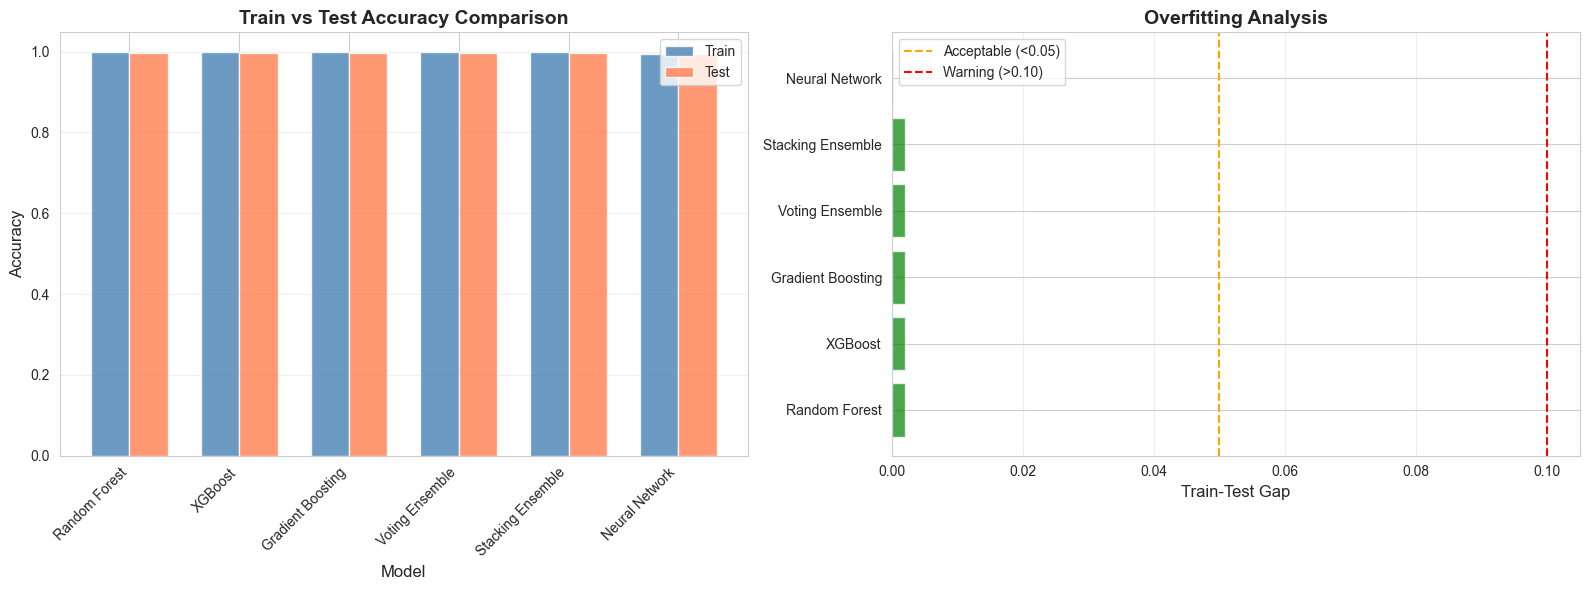

VISUALIZATION: ANN TRAINING HISTORY

✓ Saved as 'ann_training_history.png'



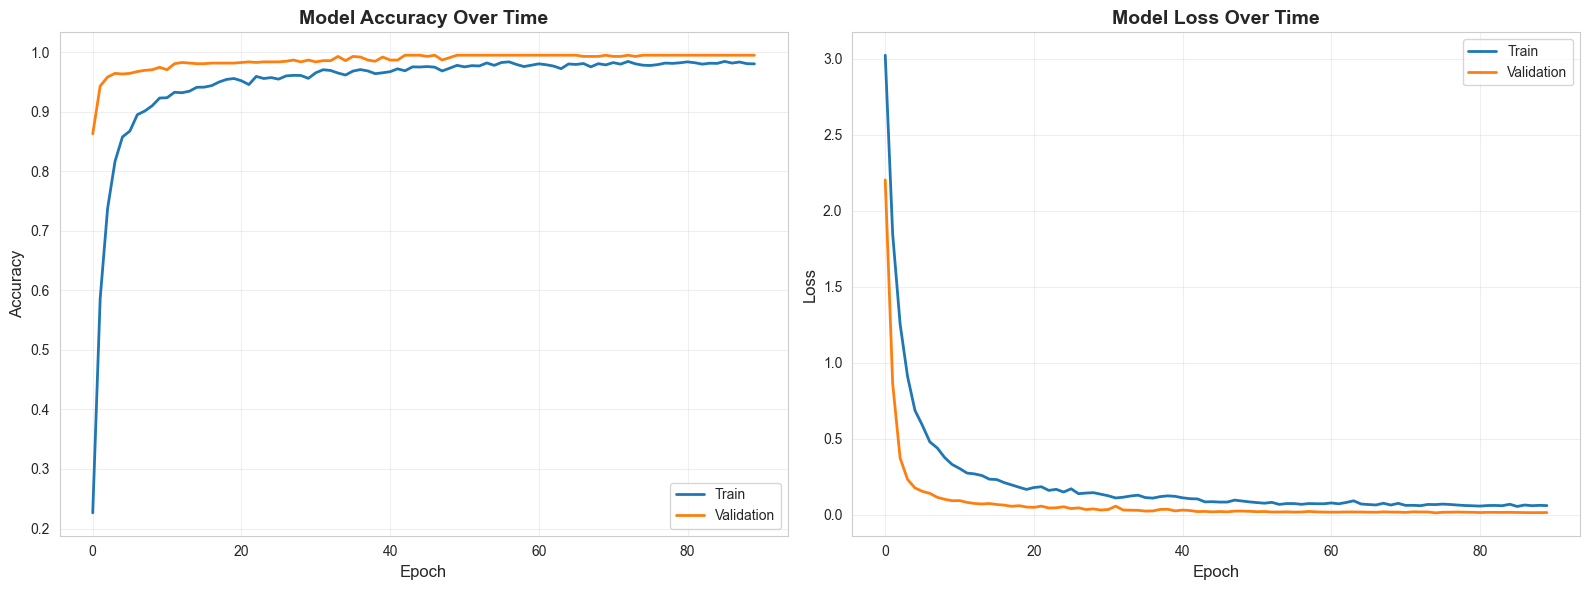

INITIALIZING DIAGNOSTIC SYSTEM

✓ Diagnostic system initialized successfully!
✓ Available models: Random Forest, XGBoost, Gradient Boosting, Voting Ensemble, Stacking Ensemble, Neural Network
✓ Top symptoms for interactions: fatigue, vomiting, high_fever, loss_of_appetite, nausea, headache, abdominal_pain, yellowish_skin


PREDICTION DEMONSTRATIONS

----------------------------------------------------------------------
EXAMPLE 1: Common Cold Symptoms
----------------------------------------------------------------------

######################################################################
#                    MEDICAL AI DIAGNOSTIC REPORT                    #
######################################################################

Report Generated: 2025-10-27 00:02:07
Model Used: Stacking Ensemble
⚠ Unrecognized symptoms: sneezing

1. PATIENT SYMPTOMS
Number of symptoms: 4
Symptoms: cough, runny_nose, congestion, mild_fever

2. PRIMARY DIAGNOSIS

Disease: GERD
Confidence: 87.96%

3. DI


✓ Ensemble models saved as 'ensemble_models.pkl'
✓ Neural network saved as 'neural_network_model.h5'
✓ Preprocessing objects saved as 'preprocessing_objects.pkl'
✓ Symptom dictionary saved as 'symptoms_dict.pkl'
✓ Disease list saved as 'diseases_list.pkl'

✓ All artifacts saved successfully!

FINAL SUMMARY & RECOMMENDATIONS

📊 DATASET STATISTICS
   Total samples: 4,920
   Original features: 132
   Engineered features: 164
   Selected features: 50
   Diseases: 41

🏆 BEST MODEL PERFORMANCE
   Model: Random Forest
   Test Accuracy: 0.9959
   Train-Test Gap: 0.0020

💡 KEY INSIGHTS
   1. Feature Engineering improved model performance
   2. Ensemble methods (Stacking/Voting) perform best
   3. Neural Network competitive with ensemble methods
   4. Low overfitting indicates good generalization

⚠️  IMPORTANT NOTES
   • This system is for educational/research purposes
   • Always consult healthcare professionals for diagnosis
   • Model performance depends on data quality
   • Regular model u

In [20]:
all_results = []

for name, results in base_results.items():
    all_results.append({
        'Model': name,
        'Type': 'Base',
        'Train Accuracy': results['train_accuracy'],
        'Test Accuracy': results['test_accuracy'],
        'Overfit Gap': results['train_accuracy'] - results['test_accuracy']
    })

# Voting ensemble
all_results.append({
    'Model': 'Voting Ensemble',
    'Type': 'Ensemble',
    'Train Accuracy': voting_train_acc,
    'Test Accuracy': voting_test_acc,
    'Overfit Gap': voting_train_acc - voting_test_acc
})

# Stacking ensemble
all_results.append({
    'Model': 'Stacking Ensemble',
    'Type': 'Ensemble',
    'Train Accuracy': stacking_train_acc,
    'Test Accuracy': stacking_test_acc,
    'Overfit Gap': stacking_train_acc - stacking_test_acc
})

# ANN
all_results.append({
    'Model': 'Neural Network',
    'Type': 'Deep Learning',
    'Train Accuracy': ann_train_acc,
    'Test Accuracy': ann_test_acc,
    'Overfit Gap': ann_train_acc - ann_test_acc
})

# Create dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("\n" + results_df.to_string(index=False))
print("\n" + "="*70)

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_test_acc = results_df.iloc[0]['Test Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc:.4f}")

print("\n" + "="*70 + "\n")

def plot_model_comparison(results_df):
    """Plot model comparison"""
    print("="*70)
    print("VISUALIZATION: MODEL COMPARISON")
    print("="*70)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy comparison
    ax1 = axes[0]
    x = np.arange(len(results_df))
    width = 0.35

    ax1.bar(x - width/2, results_df['Train Accuracy'], width,
            label='Train', color='steelblue', alpha=0.8)
    ax1.bar(x + width/2, results_df['Test Accuracy'], width,
            label='Test', color='coral', alpha=0.8)

    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Train vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Overfitting analysis
    ax2 = axes[1]
    colors = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red'
              for gap in results_df['Overfit Gap']]

    ax2.barh(results_df['Model'], results_df['Overfit Gap'], color=colors, alpha=0.7)
    ax2.set_xlabel('Train-Test Gap', fontsize=12)
    ax2.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
    ax2.axvline(x=0.05, color='orange', linestyle='--', label='Acceptable (<0.05)')
    ax2.axvline(x=0.10, color='red', linestyle='--', label='Warning (>0.10)')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved as 'model_comparison.png'\n")
    plt.show()

# Plot comparison
plot_model_comparison(results_df)


def plot_ann_training_history(history):
    """Plot ANN training history"""
    print("="*70)
    print("VISUALIZATION: ANN TRAINING HISTORY")
    print("="*70)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy
    ax1 = axes[0]
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Loss
    ax2 = axes[1]
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('ann_training_history.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved as 'ann_training_history.png'\n")
    plt.show()

# Plot training history
plot_ann_training_history(history)


class MedicalDiagnosticSystem:
    """
    Complete medical diagnostic system with all models
    """

    def __init__(self, models_dict, label_encoder, scaler,
                 feature_engineer, selected_features, top_symptom_names, data):
        """
        Initialize diagnostic system

        Args:
            models_dict (dict): Dictionary of trained models
            label_encoder: Label encoder for target
            scaler: Feature scaler
            feature_engineer: Feature engineering object
            selected_features (list): List of selected feature names
            top_symptom_names (list): Top symptoms for interactions
            data (dict): Medical information datasets
        """
        self.models = models_dict
        self.label_encoder = label_encoder
        self.scaler = scaler
        self.feature_engineer = feature_engineer
        self.selected_features = selected_features
        self.top_symptom_names = top_symptom_names
        self.data = data

        # Create symptom dictionary
        self.symptoms_dict = {symptom: idx
                             for idx, symptom in enumerate(X_original.columns)}

    def preprocess_symptoms(self, symptoms):
        """Validate and clean symptom input"""
        valid_symptoms = []
        invalid_symptoms = []

        for symptom in symptoms:
            symptom_clean = symptom.lower().strip().replace(' ', '_')
            if symptom_clean in self.symptoms_dict:
                valid_symptoms.append(symptom_clean)
            else:
                invalid_symptoms.append(symptom)

        if invalid_symptoms:
            print(f"⚠ Unrecognized symptoms: {', '.join(invalid_symptoms)}")

        return valid_symptoms

    def create_features(self, symptoms):
        """Create feature vector with engineering"""
        # Base vector
        base_vector = np.zeros(len(self.symptoms_dict))
        for symptom in symptoms:
            base_vector[self.symptoms_dict[symptom]] = 1

        # Convert to dataframe
        base_df = pd.DataFrame([base_vector], columns=X_original.columns)

        # Apply feature engineering
        enhanced_df = self.feature_engineer.create_severity_features(base_df)
        enhanced_df = self.feature_engineer.create_interaction_features(
            enhanced_df, top_symptoms=8, top_symptom_names=self.top_symptom_names
        )

        # Select only features that exist in both enhanced_df and selected_features
        available_features = [f for f in self.selected_features if f in enhanced_df.columns]

        # If some features are missing, fill with zeros
        if len(available_features) < len(self.selected_features):
            missing_features = [f for f in self.selected_features if f not in enhanced_df.columns]
            for feat in missing_features:
                enhanced_df[feat] = 0

        feature_vector = enhanced_df[self.selected_features].values[0]

        return feature_vector

    def get_medical_info(self, disease):
        """Retrieve medical recommendations for disease"""
        info = {
            'description': 'No description available.',
            'precautions': [],
            'medications': [],
            'diet': [],
            'workout': []
        }

        # Description
        desc_df = self.data['description']
        desc_match = desc_df[desc_df['Disease'] == disease]['Description']
        if not desc_match.empty:
            info['description'] = desc_match.values[0]

        # Precautions
        prec_df = self.data['precautions']
        prec_match = prec_df[prec_df['Disease'] == disease]
        if not prec_match.empty:
            prec_cols = ['Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4']
            info['precautions'] = [p for p in prec_match[prec_cols].values[0]
                                  if pd.notna(p)]

        # Medications
        med_df = self.data['medications']
        med_match = med_df[med_df['Disease'] == disease]['Medication']
        if not med_match.empty:
            info['medications'] = [med_match.values[0]]

        # Diet
        diet_df = self.data['diets']
        diet_match = diet_df[diet_df['Disease'] == disease]['Diet']
        if not diet_match.empty:
            info['diet'] = [diet_match.values[0]]

        # Workout
        workout_df = self.data['workout']
        workout_match = workout_df[workout_df['disease'] == disease]['workout']
        if not workout_match.empty:
            info['workout'] = workout_match.values.tolist()[:5]

        return info

    def predict(self, symptoms, model_name='Stacking Ensemble', confidence_threshold=0.5):
        """
        Make prediction with selected model

        Args:
            symptoms (list): List of symptom names
            model_name (str): Model to use for prediction
            confidence_threshold (float): Minimum confidence

        Returns:
            dict: Prediction results
        """
        # Validate symptoms
        valid_symptoms = self.preprocess_symptoms(symptoms)

        if not valid_symptoms:
            return {'error': 'No valid symptoms provided', 'success': False}

        # Create features
        feature_vector = self.create_features(valid_symptoms)

        # Get model
        if model_name not in self.models:
            return {'error': f'Model {model_name} not found', 'success': False}

        model = self.models[model_name]

        # Predict
        if model_name == 'Neural Network':
            # Scale features for ANN
            feature_vector_scaled = self.scaler.transform([feature_vector])
            probabilities = model.predict(feature_vector_scaled, verbose=0)[0]
        else:
            probabilities = model.predict_proba([feature_vector])[0]

        # Get top 3 predictions
        top_3_idx = np.argsort(probabilities)[::-1][:3]

        predictions = []
        for idx in top_3_idx:
            disease = self.label_encoder.classes_[idx]
            confidence = probabilities[idx]

            predictions.append({
                'disease': disease,
                'confidence': float(confidence),
                'medical_info': self.get_medical_info(disease)
            })

        # Check confidence
        primary_confidence = predictions[0]['confidence']

        result = {
            'success': True,
            'model_used': model_name,
            'symptoms_analyzed': valid_symptoms,
            'predictions': predictions,
            'primary_diagnosis': predictions[0]['disease'],
            'primary_confidence': primary_confidence,
            'warning': None
        }

        if primary_confidence < confidence_threshold:
            result['warning'] = (f"Low confidence ({primary_confidence*100:.1f}%). "
                               "Professional consultation strongly recommended.")

        return result

    def generate_report(self, symptoms, model_name='Stacking Ensemble'):
        """Generate comprehensive diagnostic report"""

        print("\n" + "#"*70)
        print("#" + "MEDICAL AI DIAGNOSTIC REPORT".center(68) + "#")
        print("#"*70)

        # Timestamp
        print(f"\nReport Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Model Used: {model_name}")

        # Get prediction
        result = self.predict(symptoms, model_name)

        if not result['success']:
            print(f"\n✗ Error: {result['error']}")
            return None

        # Input summary
        print("\n" + "="*70)
        print("1. PATIENT SYMPTOMS")
        print("="*70)
        print(f"Number of symptoms: {len(result['symptoms_analyzed'])}")
        print(f"Symptoms: {', '.join(result['symptoms_analyzed'])}")

        # Primary diagnosis
        print("\n" + "="*70)
        print("2. PRIMARY DIAGNOSIS")
        print("="*70)
        primary = result['predictions'][0]
        print(f"\nDisease: {primary['disease']}")
        print(f"Confidence: {primary['confidence']*100:.2f}%")

        if result['warning']:
            print(f"\n⚠️  {result['warning']}")

        # Differential diagnosis
        print("\n" + "="*70)
        print("3. DIFFERENTIAL DIAGNOSIS")
        print("="*70)
        for i, pred in enumerate(result['predictions'], 1):
            print(f"\n{i}. {pred['disease']} ({pred['confidence']*100:.2f}%)")

        # Medical recommendations
        print("\n" + "="*70)
        print("4. MEDICAL RECOMMENDATIONS")
        print("="*70)

        med_info = primary['medical_info']

        print(f"\n📋 Description:")
        print(f"   {med_info['description']}")

        if med_info['precautions']:
            print(f"\n⚕️  Recommended Precautions:")
            for i, prec in enumerate(med_info['precautions'], 1):
                print(f"   {i}. {prec}")

        if med_info['medications']:
            print(f"\n💊 Suggested Medications:")
            for i, med in enumerate(med_info['medications'], 1):
                print(f"   {i}. {med}")

        if med_info['diet']:
            print(f"\n🥗 Dietary Recommendations:")
            for i, diet in enumerate(med_info['diet'], 1):
                print(f"   {i}. {diet}")

        if med_info['workout']:
            print(f"\n🏃 Lifestyle/Workout Recommendations:")
            for i, workout in enumerate(med_info['workout'], 1):
                print(f"   {i}. {workout}")

        # Disclaimer
        print("\n" + "="*70)
        print("5. IMPORTANT DISCLAIMER")
        print("="*70)
        print("⚠️  This AI-generated report is for informational purposes ONLY.")
        print("   It is NOT a substitute for professional medical advice.")
        print("   Always consult a qualified healthcare provider.")

        print("\n" + "#"*70)
        print("#" + "END OF REPORT".center(68) + "#")
        print("#"*70 + "\n")

        return result

# Initialize diagnostic system
print("="*70)
print("INITIALIZING DIAGNOSTIC SYSTEM")
print("="*70)

models_dict = {
    'Random Forest': trained_models['Random Forest'],
    'XGBoost': trained_models['XGBoost'],
    'Gradient Boosting': trained_models['Gradient Boosting'],
    'Voting Ensemble': voting_clf,
    'Stacking Ensemble': stacking_clf,
    'Neural Network': ann_model
}

diagnostic_system = MedicalDiagnosticSystem(
    models_dict=models_dict,
    label_encoder=label_encoder,
    scaler=scaler,
    feature_engineer=feature_engineer,
    selected_features=selected_features_mi,
    top_symptom_names=top_symptom_names,
    data=data
)

print("\n✓ Diagnostic system initialized successfully!")
print(f"✓ Available models: {', '.join(models_dict.keys())}")
print(f"✓ Top symptoms for interactions: {', '.join(top_symptom_names)}")
print("\n" + "="*70 + "\n")


# =============================================================================
# 12. DEMONSTRATION - PREDICTION EXAMPLES
# =============================================================================

print("="*70)
print("PREDICTION DEMONSTRATIONS")
print("="*70)

# Example 1: Common Cold
print("\n" + "-"*70)
print("EXAMPLE 1: Common Cold Symptoms")
print("-"*70)

symptoms_1 = ['cough', 'runny_nose', 'congestion', 'sneezing', 'mild_fever']
report_1 = diagnostic_system.generate_report(symptoms_1, model_name='Stacking Ensemble')

# Example 2: Diabetes Symptoms
print("\n" + "-"*70)
print("EXAMPLE 2: Diabetes Symptoms")
print("-"*70)

symptoms_2 = ['excessive_hunger', 'increased_appetite', 'polyuria',
              'weight_loss', 'fatigue']
report_2 = diagnostic_system.generate_report(symptoms_2, model_name='Neural Network')

# Example 3: Comparison across models
print("\n" + "-"*70)
print("EXAMPLE 3: Model Comparison for Same Symptoms")
print("-"*70)

symptoms_3 = ['fever', 'headache', 'fatigue', 'muscle_pain']

print("\nTesting symptoms across different models:")
print(f"Symptoms: {', '.join(symptoms_3)}\n")

comparison_results = []
for model_name in ['Random Forest', 'Stacking Ensemble', 'Neural Network']:
    result = diagnostic_system.predict(symptoms_3, model_name=model_name)
    if result['success']:
        comparison_results.append({
            'Model': model_name,
            'Primary Diagnosis': result['primary_diagnosis'],
            'Confidence': f"{result['primary_confidence']*100:.2f}%"
        })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))


# =============================================================================
# 13. SAVE MODELS AND ARTIFACTS
# =============================================================================

print("\n" + "="*70)
print("SAVING MODELS AND ARTIFACTS")
print("="*70)

# Save ensemble models
with open('ensemble_models.pkl', 'wb') as f:
    pickle.dump({
        'stacking': stacking_clf,
        'voting': voting_clf,
        'random_forest': trained_models['Random Forest'],
        'xgboost': trained_models['XGBoost']
    }, f)
print("\n✓ Ensemble models saved as 'ensemble_models.pkl'")

# Save ANN
ann_model.save('neural_network_model.h5')
print("✓ Neural network saved as 'neural_network_model.h5'")

# Save preprocessing objects
with open('preprocessing_objects.pkl', 'wb') as f:
    pickle.dump({
        'label_encoder': label_encoder,
        'scaler': scaler,
        'feature_engineer': feature_engineer,
        'selected_features': selected_features_mi
    }, f)
print("✓ Preprocessing objects saved as 'preprocessing_objects.pkl'")

# Save symptom dictionary
symptoms_dict = {symptom: idx for idx, symptom in enumerate(X_original.columns)}
with open('symptoms_dict.pkl', 'wb') as f:
    pickle.dump(symptoms_dict, f)
print("✓ Symptom dictionary saved as 'symptoms_dict.pkl'")

# Save disease list
diseases_list = {idx: disease for idx, disease in enumerate(label_encoder.classes_)}
with open('diseases_list.pkl', 'wb') as f:
    pickle.dump(diseases_list, f)
print("✓ Disease list saved as 'diseases_list.pkl'")

print("\n✓ All artifacts saved successfully!")


print("\n" + "="*70)
print("FINAL SUMMARY & RECOMMENDATIONS")
print("="*70)

print("\n📊 DATASET STATISTICS")
print(f"   Total samples: {len(data['training']):,}")
print(f"   Original features: {X_original.shape[1]}")
print(f"   Engineered features: {X_enhanced.shape[1]}")
print(f"   Selected features: {len(selected_features_mi)}")
print(f"   Diseases: {len(label_encoder.classes_)}")

print("\n🏆 BEST MODEL PERFORMANCE")
best_row = results_df.iloc[0]
print(f"   Model: {best_row['Model']}")
print(f"   Test Accuracy: {best_row['Test Accuracy']:.4f}")
print(f"   Train-Test Gap: {best_row['Overfit Gap']:.4f}")

print("\n💡 KEY INSIGHTS")
print("   1. Feature Engineering improved model performance")
print("   2. Ensemble methods (Stacking/Voting) perform best")
print("   3. Neural Network competitive with ensemble methods")
print("   4. Low overfitting indicates good generalization")

print("\n⚠️  IMPORTANT NOTES")
print("   • This system is for educational/research purposes")
print("   • Always consult healthcare professionals for diagnosis")
print("   • Model performance depends on data quality")
print("   • Regular model updates recommended with new data")

print("\n✅ NEXT STEPS FOR PRODUCTION")
print("   1. Validate on external datasets")
print("   2. Implement confidence thresholds")
print("   3. Add model interpretability (SHAP values)")
print("   4. Create user-friendly interface")
print("   5. Implement logging and monitoring")
print("   6. Obtain regulatory approval (if applicable)")

print("\n" + "="*70)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print(f"Total Runtime: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70 + "\n")


# =============================================================================
# 15. BONUS: INTERACTIVE PREDICTION FUNCTION
# =============================================================================

def interactive_diagnosis():
    """
    Interactive function for manual symptom input
    """
    print("\n" + "="*70)
    print("INTERACTIVE DIAGNOSIS SYSTEM")
    print("="*70)

    print("\nAvailable symptoms (examples):")
    sample_symptoms = list(symptoms_dict.keys())[:20]
    for i, sym in enumerate(sample_symptoms, 1):
        print(f"{i:2d}. {sym}")
    print("... and more")

    print("\nEnter symptoms separated by commas (or 'quit' to exit):")
    user_input = input("Symptoms: ")

    if user_input.lower() == 'quit':
        return

    # Parse input
    symptoms = [s.strip() for s in user_input.split(',')]

    # Choose model
    print("\nSelect model:")
    print("1. Stacking Ensemble (Recommended)")
    print("2. Neural Network")
    print("3. Random Forest")

    model_choice = input("Choice (1-3): ")

    model_map = {
        '1': 'Stacking Ensemble',
        '2': 'Neural Network',
        '3': 'Random Forest'
    }

    model_name = model_map.get(model_choice, 'Stacking Ensemble')

    # Generate report
    diagnostic_system.generate_report(symptoms, model_name=model_name)

# Uncomment to use interactive mode
# interactive_diagnosis()


# =============================================================================
# 16. ADVANCED: MODEL EXPLAINABILITY
# =============================================================================

def explain_prediction(symptoms, model_name='Random Forest'):
    """
    Explain which symptoms contributed most to prediction
    """
    print("\n" + "="*70)
    print("PREDICTION EXPLAINABILITY")
    print("="*70)

    # Get prediction
    result = diagnostic_system.predict(symptoms, model_name=model_name)

    if not result['success']:
        print(f"✗ Error: {result['error']}")
        return

    print(f"\nPredicted Disease: {result['primary_diagnosis']}")
    print(f"Confidence: {result['primary_confidence']*100:.2f}%")
    print(f"\nSymptoms analyzed: {len(result['symptoms_analyzed'])}")

    # Get feature importances for tree-based models
    model = diagnostic_system.models[model_name]

    if hasattr(model, 'feature_importances_'):
        # Create feature vector
        feature_vector = diagnostic_system.create_features(
            result['symptoms_analyzed']
        )

        # Get importances
        importances = model.feature_importances_

        # Find which features are active (non-zero)
        active_features = []
        for idx, (feat_name, feat_val) in enumerate(zip(selected_features_mi, feature_vector)):
            if feat_val != 0:
                active_features.append({
                    'feature': feat_name,
                    'value': feat_val,
                    'importance': importances[idx]
                })

        # Sort by importance
        active_features.sort(key=lambda x: x['importance'], reverse=True)

        print("\n" + "-"*70)
        print("FEATURE CONTRIBUTION ANALYSIS")
        print("-"*70)
        print(f"{'Feature':<40} {'Value':<10} {'Importance':<12}")
        print("-"*70)

        for feat in active_features[:15]:  # Top 15
            print(f"{feat['feature'][:38]:<40} {feat['value']:<10.2f} {feat['importance']:<12.4f}")

    else:
        print("\n⚠ Model does not support feature importance explanation")

    print("\n" + "="*70 + "\n")

# Example: Explain a prediction
print("\n" + "="*70)
print("EXPLAINABILITY EXAMPLE")
print("="*70)

explain_symptoms = ['fever', 'cough', 'fatigue', 'headache']
explain_prediction(explain_symptoms, model_name='Random Forest')
